<a href="https://colab.research.google.com/github/Mohannad-Mismar/deeplearning-pytorch-classifacation/blob/main/dp_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Mohannad Mismar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 724MB/s]

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
df.dropna(inplace = True)
df.drop(["id"],axis = 1 , inplace = True)
print("Output possibilities: ", df["Class"].unique())
print(df.shape)
df.head()

Output possibilities:  [1 0]
(18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Normalization

In [ ]:
original_df = df.copy()
for column in df.columns :
  df[column] = df[column]/df[column].abs().max()
df.head()

# a = (5, 3)
# b = a
# # a += 4
# a.append(4)
# print(b)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


Data splitting

In [ ]:
x = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test ,test_size=0.5)
print("Training set is: ", x_train.shape[0], " rows which is ", round(x_train.shape[0]/df.shape[0],4)*100, "%")
print("Validation set is: ",x_val.shape[0], " rows which is ", round(x_val.shape[0]/df.shape[0],4)*100, "%")
print("Testing set is: ",x_test.shape[0], " rows which is ", round(x_test.shape[0]/df.shape[0],4)*100, "%")

Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


In [ ]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x, dtype=torch.float32).to(device)
    self.y = torch.tensor(y, dtype=torch.float32).to(device)
  def __len__(self):
        return len(self.x)
  def __getitem__(self, index):
        return self.x[index], self.y[index]

training_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
testing_data = dataset(x_test, y_test)

In [ ]:
training_dataloader = DataLoader(training_data, batch_size= 64, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size= 64, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size= 64, shuffle= True)

In [ ]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
    def __init__(self):

        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(x.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [ ]:
model = MyModel().to(device)
summary(model, (x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= 1e-3)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(10):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in training_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)


Epoch no. 1 Train Loss: 0.1332 Train Accuracy: 52.7614 Validation Loss: 0.0266 Validation Accuracy: 71.1144
Epoch no. 2 Train Loss: 0.1073 Train Accuracy: 94.2101 Validation Loss: 0.0196 Validation Accuracy: 97.2141
Epoch no. 3 Train Loss: 0.0726 Train Accuracy: 97.5489 Validation Loss: 0.0124 Validation Accuracy: 97.6540
Epoch no. 4 Train Loss: 0.0452 Train Accuracy: 98.0046 Validation Loss: 0.0079 Validation Accuracy: 97.6906
Epoch no. 5 Train Loss: 0.0300 Train Accuracy: 98.2245 Validation Loss: 0.0056 Validation Accuracy: 98.0572
Epoch no. 6 Train Loss: 0.0220 Train Accuracy: 98.4209 Validation Loss: 0.0044 Validation Accuracy: 98.0938
Epoch no. 7 Train Loss: 0.0176 Train Accuracy: 98.4209 Validation Loss: 0.0036 Validation Accuracy: 98.3504
Epoch no. 8 Train Loss: 0.0149 Train Accuracy: 98.5231 Validation Loss: 0.0032 Validation Accuracy: 98.2405
Epoch no. 9 Train Loss: 0.0131 Train Accuracy: 98.5781 Validation Loss: 0.0029 Validation Accuracy: 98.4604
Epoch no. 10 Train Loss: 0.0

In [ ]:
#testing
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/x_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.9%


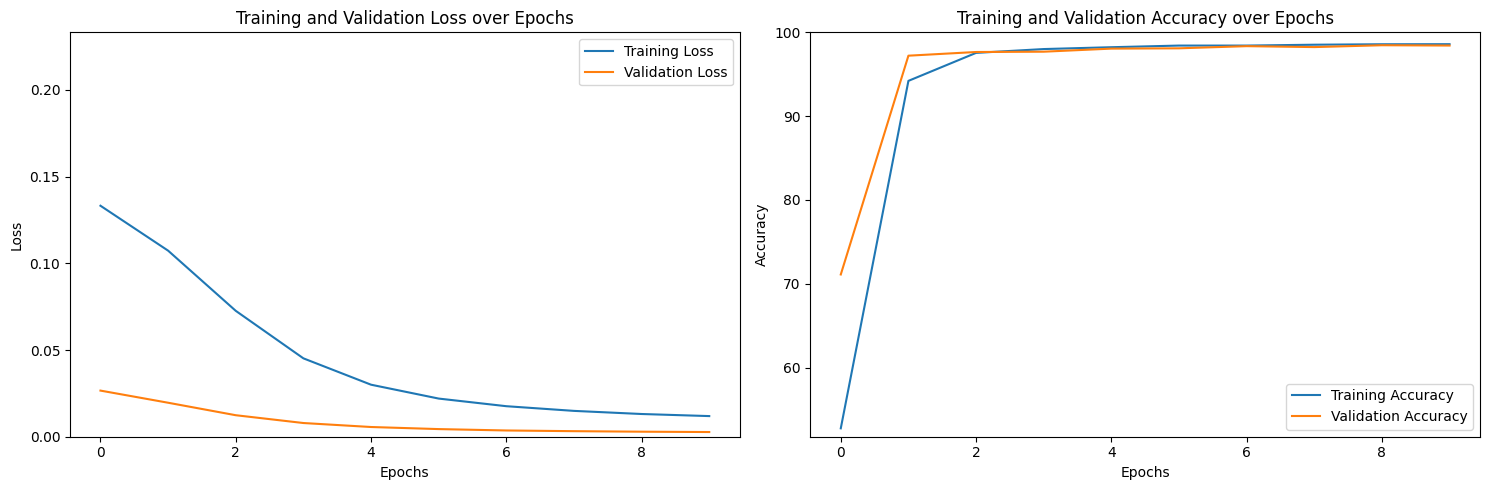

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, max(max(total_loss_train_plot), max(total_loss_validation_plot)) + 0.1]) # Adjust y-axis limit
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([min(min(total_acc_train_plot), min(total_acc_validation_plot)) - 1, 100]) # Adjust y-axis limit
axs[1].legend()

plt.tight_layout()

plt.show()